<font size='4'>
    <b> Welcome to: Pregnancy Hypertension Disorder Prediction Model </b><br><br>
    <u> Project Model Pipeline: </u><br>
    <ul>
        <li> (1) Read Data: Pregnancy Hypertension Disorders </li>
        <li> (2) EDA </li>
        <li> (3) Preprocessing Data: (5.1) Text Data and (5.2) Tabular Data </li>
        <li> (4) Model Training & Testing </li>
        <li> (5) Model Explainability: Local Shap </li>
        <li> (6) Model Fairness and Calibration: (8.1) Age and (8.2) Income Level </li>    
    </ul>
    Python Support: python v=3.10.x <br>
    GPU Support: Tensorflow v=2.14.x <br>
    Author: Edo Lior <br>
    Created: June, 2025 <br>
</font>

<font size='4'>
    <b> Steps to run code: </b><br>
    <ul>
        <li> (1) Before running, choose your configuration settings in the sector "Main Project Model Pipeline" which is located at the bottom of the ipynb file (default values can be used): </li>
        <li> (1.1) Project path </li>
        <li> (1.2) Dataset name </li>
        <li> (1.3) Running on a full or sampled dataset </li>
        <li> (1.4) Define a threshold fixed percentage value </li>
        <li> (2) Run cells </li>   
        <li> (3) That's it! </li>  
    </ul>
</font>

In [41]:
import os
import shutil

from collections import defaultdict
import pandas as pd
import numpy as np
import random
import itertools
import string
import re
from datetime import datetime

from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import *
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.utils import shuffle
import joblib
import time
from tqdm import tqdm

from sklearn.ensemble import RandomForestRegressor
from sklearn.calibration import *
from sklearn.feature_selection import SelectKBest, chi2
import shap

import seaborn as sns
import colorcet as cc
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import matplotlib.transforms as mtransform
from matplotlib.gridspec import GridSpec
%matplotlib inline

In [42]:
# Installations - if not using environment

# !pip install pandas numpy
# !pip install scikit-learn
# !pip install seaborn matplotlib colorcet
# !pip install shap
# !pip install tqdm

<b> Set Path Directories </b>

In [43]:
def set_path(p_full, filename=None):
    """
    function writes path directory to disk
    :param p_full: full path or parent path
    :param filename: child file name
    :return: full path
    """
    if filename is not None:
        p_full = os.path.join(p_full, filename)
    if not os.path.exists(p_full):
        os.makedirs(p_full)
    return p_full

def check_file_exists(p_file):
    """
    function checks if a file exists
    :param p_file: path to directory
    :return: boolean
    """
    return os.path.exists(p_file)

<b> Read Data </b>

In [44]:
def read_data(p_input_data, i_sample):
    """
    function reads dataframe in 'csv' format
    :param p_input_data: path to input dataset directory
    :param i_sample: int value to run on a sample of the data; set i_sample=0 to run on all the data
    :return: dataframe
    """
    if i_sample == 0:
        df_data = pd.read_csv(p_input_data)
    else:
        df_data = pd.read_csv(p_input_data, nrows=i_sample)
    return df_data

def get_df_columns(df_data):
    """
    function returns list of columns by types
    feature categories:
    (1) demographics
    (2) medical categories: (2.1) smoking history, (2.2) lab results and (2.3) measurements
    (3) history diagnoses
    (4) classes diagnosis and origin data: (4.1) ICD9 Codes, (4.2) Blood Pressure, (4.3) Patient Registered, (4.4) Low-Dose Aspirin, OR (4.5) Patient Admission/Patient Discharge
    :param df_data: dataset dataframe
    :return: list of df columns
    """
    count_cols = df_data.shape[1]
    print(f'Dataset number of columns: {count_cols}')

    # features: (1) demographics
    l_cols_demographics = ['demog_capitationcoefficient', 'demog_customer_age']

    # features: (2) medical categories: (2.1) 'smoking history', (2.2) 'lab results' and (2.3) 'measurements'
    l_cols_features = ['smoking_is_smoker', 'smoking_smoking_years', 'smoking_total_heavy_smokers',
                       'lab_b_hcg_abs_last_value', 'lab_NT_MoM_last_value', 'lab_weight_at_lab_time_last_value',
                       'lab_num_of_fetuses_last_value', 'lab_NT_abs_last_value', 'lab_papp_a_abs_last_value',
                       'lab_papp_a_MoM_last_value', 'lab_Protein-U_last_value', 'lab_Monocytes_1_last_value',
                       'lab_Mean Platelet Volume (MPV)_last_value', 'lab_Hemoglobin (HGB)_last_value',
                       'lab_Hematocrit (HCT)_last_value', 'lab_Red Blood Cells (RBC)_last_value',
                       'lab_Red Cell Count (RCC)_last_value', 'lab_Mean Corpuscular Hemoglobin (MCH)_last_value',
                       'lab_Mean Corpuscular Hemoglobin Concentration (MCHC)_last_value',
                       'lab_Red Cell Distribution Width (RDW)_last_value', 'lab_Platelets (PLT)_last_value',
                       'lab_Eosinophils_1_last_value', 'lab_White Blood Cells (WBC)_last_value',
                       'lab_Lymphocytes_1_last_value', 'lab_Neutrophils_1_last_value',
                       'lab_Eosinophils_2_last_value', 'lab_Basophils_1_last_value', 'lab_Neutrophils_2_last_value',
                       'lab_Lymphocytes_2_last_value', 'lab_Monocytes_2_last_value',
                       'measure_blood_pressure_dias_count', 'measure_blood_pressure_dias_max_val',
                       'measure_blood_pressure_dias_min_val', 'measure_blood_pressure_dias_mean_val',
                       'measure_blood_pressure_dias_stddev_val', 'measure_blood_pressure_dias_first_val',
                       'measure_blood_pressure_dias_last_val', 'measure_blood_pressure_dias_min_max_percent',
                       'measure_blood_pressure_dias_first_last_percent',
                       'measure_blood_pressure_dias_last_before_last_percent', 'measure_blood_pressure_sys_count',
                       'measure_blood_pressure_sys_max_val', 'measure_blood_pressure_sys_min_val',
                       'measure_blood_pressure_sys_mean_val', 'measure_blood_pressure_sys_stddev_val',
                       'measure_blood_pressure_sys_first_val', 'measure_blood_pressure_sys_last_val',
                       'measure_blood_pressure_sys_min_max_percent',
                       'measure_blood_pressure_sys_first_last_percent',
                       'measure_blood_pressure_sys_last_before_last_percent']

    # features: (3) history diagnoses
    l_cols_history_diagnoses = ['24_diag_53_days_since_last_diag', '24_diag_54_num_of_diag',
                                '24_diag_55_days_since_last_diag',
                                '24_diag_56_num_of_diag', '24_diag_57_days_since_last_diag',
                                '24_diag_58_num_of_diag',
                                '24_diag_59_days_since_last_diag', '24_diag_60_num_of_diag',
                                '24_diag_61_days_since_last_diag',
                                '24_diag_62_num_of_diag', '24_diag_63_days_since_last_diag',
                                '24_diag_64_num_of_diag',
                                '24_diag_65_days_since_last_diag', '24_diag_66_num_of_diag',
                                '24_diag_67_days_since_last_diag',
                                '24_diag_68_num_of_diag', '24_diag_69_days_since_last_diag',
                                '24_diag_70_num_of_diag',
                                '24_diag_71_days_since_last_diag', '24_diag_72_num_of_diag',
                                '24_diag_73_days_since_last_diag',
                                '24_diag_74_num_of_diag', '24_diag_75_days_since_last_diag',
                                '24_diag_76_num_of_diag',
                                '24_diag_77_days_since_last_diag', '24_diag_78_num_of_diag',
                                '24_diag_79_days_since_last_diag',
                                '24_diag_80_num_of_diag', '24_diag_81_days_since_last_diag',
                                '24_diag_82_num_of_diag',
                                '24_diag_83_days_since_last_diag', '24_diag_84_num_of_diag',
                                '24_diag_85_days_since_last_diag',
                                '24_diag_86_num_of_diag', '24_diag_87_days_since_last_diag',
                                '4_diag_88_days_since_last_diag',
                                '4_diag_89_num_of_diag', '4_diag_90_days_since_last_diag', '4_diag_91_num_of_diag',
                                '4_diag_92_days_since_last_diag', '4_diag_93_num_of_diag',
                                '4_diag_94_days_since_last_diag',
                                '4_diag_95_num_of_diag', '4_diag_96_days_since_last_diag', '4_diag_97_num_of_diag',
                                '4_diag_98_days_since_last_diag', '4_diag_99_num_of_diag',
                                '4_diag_100_days_since_last_diag',
                                '4_diag_101_num_of_diag', '4_diag_102_days_since_last_diag',
                                '4_diag_103_num_of_diag',
                                '4_diag_104_days_since_last_diag', '4_diag_105_num_of_diag',
                                '4_diag_106_days_since_last_diag',
                                '4_diag_107_num_of_diag', '4_diag_108_days_since_last_diag',
                                '4_diag_109_num_of_diag',
                                '4_diag_110_days_since_last_diag', '4_diag_111_num_of_diag',
                                '4_diag_112_days_since_last_diag',
                                '4_diag_113_num_of_diag', '4_diag_114_days_since_last_diag',
                                '4_diag_115_num_of_diag',
                                '4_diag_116_days_since_last_diag', '4_diag_117_num_of_diag',
                                '4_diag_118_days_since_last_diag',
                                '4_diag_119_num_of_diag', '4_diag_120_days_since_last_diag',
                                '4_diag_121_num_of_diag',
                                '4_diag_122_days_since_last_diag', '4_diag_123_num_of_diag',
                                '4_diag_124_days_since_last_diag',
                                '4_diag_125_num_of_diag', '4_diag_126_days_since_last_diag',
                                '4_diag_127_num_of_diag',
                                '4_diag_128_days_since_last_diag', '4_diag_129_num_of_diag',
                                '4_diag_130_days_since_last_diag',
                                '4_diag_131_num_of_diag', '4_diag_132_days_since_last_diag',
                                '4_diag_133_num_of_diag',
                                '4_diag_134_days_since_last_diag', '4_diag_135_num_of_diag',
                                '4_diag_136_days_since_last_diag',
                                '4_diag_137_num_of_diag', '4_diag_138_days_since_last_diag',
                                '4_diag_139_num_of_diag',
                                '4_diag_140_days_since_last_diag']

    # features: (4) classes diagnosis and origin data: (4.1) ICD9 Codes, (4.2) Blood Pressure, (4.3) Patient Registered, (4.4) Low-Dose Aspirin, OR (4.5) Patient Admission/Patient Discharge
    l_cols_classes = ['match_diag_141', 'match_measure_after', 'match_rasham_after', 'match_aspirin_after',
                      'match_pdf_after', 'Y', 'secondary_hypertension_sum', 'essential_hypertension_sum',
                      'hypertensive_heart_disease_sum', 'hypertensive_chronic_kidney_disease_sum',
                      'hypertensive_heart_and_chronic_kidney_disease_sum', 'pregnancy_hypertension_sum',
                      'preeclampsia_sum', 'eclampsia_sum', 'labs_sum']

    col_date = 'int_date'
    col_text = 'clinical_sheet'
    d_cols = {'Date': [col_date],
              'Demographics': l_cols_demographics,
              'Features': l_cols_features,
              'HistoryDiagnoses': l_cols_history_diagnoses,
              'Classes': l_cols_classes,
              'Text': ['clinical_sheet']
              }
    return d_cols, col_date, col_text

<b> Data Analysis - EDA </b>

In [45]:
def set_onehot_encoding(df_curr):
    """
    function lists one-hot encoding column features
    :param df_curr: current dataframe
    """
    count_cols_onehot = df_curr.select_dtypes(include='object').columns
    if len(count_cols_onehot) > 0:
        print('Dataset contains the following onehot object type columns: ')
        print(count_cols_onehot.tolist())
    else:
        print('Onehot Encodings Detected: 0.')

def apply_df_format_types(df_data):
    """
    function displays format types
    :param df_data: current dataframe
    :return: format types
    """
    if pd.api.types.is_string_dtype(df_data):
        return 'object'
    elif pd.api.types.is_integer_dtype(df_data):
        return 'int'
    elif pd.api.types.is_float_dtype(df_data):
        return 'float'
    elif pd.api.types.is_bool_dtype(df_data):
        return 'bool'
    elif pd.api.types.is_datetime64_any_dtype(df_data):
        return 'datetime'
    else:
        return str(df_data)

def get_df_format_types(df_data):
    """
    function displays format types
    :param df_data: current dataframe
    """
    curr_types = df_data.dtypes.apply(apply_df_format_types)
    count_types = curr_types.value_counts()
    print('Dataset column data format types:')
    for curr_formay_type, curr_count in count_types.items():
        print(f'{curr_formay_type}: {curr_count}')

def get_missing_data_ratio(df_curr):
    """
    function calculates missing data
    :param df_curr: current dataframe
    :return: dict of percentages
    """
    d_percentages = dict()
    l_missing = list()
    d_annotations = defaultdict(str)
    for s_curr_col in df_curr.columns.tolist():
        i_null = df_curr[s_curr_col].isnull().sum()
        i_full = df_curr.shape[0]
        i_exist = i_full - i_null
        f_perc = round((i_exist / i_full) * 100, 2)
        f_missing = round((1 - (i_exist / i_full)) * 100)
        d_percentages[s_curr_col] = float(f_missing)
        i_null = int(i_null)
        f_perc_missing = round((i_null / i_full) * 100, 2)
        s_missing = '{}'.format(f_perc_missing)
        if i_null > 0:
            l_missing.append([s_curr_col, s_missing])
        s_exist = '{}'.format(i_exist)
        d_annotations[s_curr_col] = s_exist
        print('Feature: %s, Data Exists: %.2f%%, Data Missing: %.2f%%' % (s_curr_col, f_perc, f_missing))
    if len(l_missing) > 0:
        for curr_feature_missing_values in l_missing:
            curr_feature = curr_feature_missing_values[0]
            curr_missing_values = curr_feature_missing_values[1]
            print(f'Missing Values Feature {curr_feature}: {curr_missing_values}%')
    return d_percentages

def save_plot(plt, p_output_plot):
    """
    functions saves plots
    :param plt: plot object
    :param p_output_plot: plot path to write
    """
    p_save = p_output_plot + '.png'
    _dpi = 300  # dots per inch
    plt.savefig(p_save, dpi=_dpi)

def plot_data(df_curr, plot_type, plot_title, x_title, y_title, p_plots):
    """
    function plots graphs
    :param df_curr: input dataframe
    :param plot_type: type of the plot
    :param plot_title: title name
    :param x_title: x axis name
    :param y_title: y axis name
    :param p_plots: output path to save plots
    :return: displays plot and saves to disk
    """
    count_cols, count_rows = df_curr.shape[1], df_curr.shape[0]
    print(f'Dataset Category: {plot_title}. \n Records: {int(count_rows)}, Features: {int(count_cols)}')
    plt.figure(figsize=(10, 10))
    p_plot_output = os.path.join(p_plots, plot_title)

    if plot_type == 'bar':
        if 'Date' not in plot_title:
            avg_value = round(df_curr['Count'].mean(), 2)
            _palette = sns.color_palette(cc.glasbey, n_colors=count_cols)
            g_bar = sns.barplot(x='Label', y='Count', data=df_curr, hue='Label', palette=_palette, legend=False)
            for curr_bar in g_bar.patches:
                g_bar.annotate(f'{int(curr_bar.get_height())}',
                               (curr_bar.get_x() + curr_bar.get_width() / 2., curr_bar.get_height()),
                               ha='center', va='bottom', fontsize=10, color='black')
            plt.axhline(y=avg_value, color='red', linestyle='--', label=f'AVG Count: {avg_value}')
        else:
            sns.barplot(x='Label', y='Count', data=df_curr, hue='Label', palette='viridis', legend=False)
        plt.xlabel(x_title)
        plt.ylabel(y_title)
        if count_cols > 6:
            plt.xticks(rotation=90, fontsize=8)
        plt.legend()

    elif plot_type == 'pie':
        _colors = random.choices(list(mcolors.CSS4_COLORS.keys()), k=count_cols)
        plt.pie(df_curr.Count, labels=df_curr.Label, colors=_colors, autopct='%.1f%%', rotatelabels=True, shadow=False, startangle=140, textprops={'fontsize': 8})
        plt.axis('equal')  # ensures pie is drawn as a circle

    plt.title(plot_title)
    save_plot(plt, p_plot_output)
    plt.show()
    plt.clf()

def plot_histogram(df_curr, l_curr_cols, p_plots):
    """
    functions plots a histogram of features
    :param df_curr: current dataframe
    :param l_curr_cols: list of current columns
    :param p_plots: path to save plot
    :return: displays plot and saves to disk
    """
    for curr_col in l_curr_cols:
        _bins = 10
        plot_title = ''
        if curr_col == 'demog_customer_age':
            plot_title = 'Age'
        elif curr_col == 'demog_capitationcoefficient':
            plot_title = 'Income Level'
        elif curr_col == 'lab_weight_at_lab_time_last_value':
            plot_title = 'Weight'
        p_plot_output = os.path.join(p_plots, plot_title)
        sns.histplot(data=df_curr, x=df_curr[curr_col], kde=True, bins=_bins)
        plt.title(plot_title + ': Distribution')
        plt.xlabel(plot_title)
        plt.ylabel('Frequency')
        plt.tight_layout()
        save_plot(plt, p_plot_output)
        plt.show()
        plt.clf()

def plot_missing_data_ratio(d_curr_percentages, key_curr_category, p_plots):
    """
    function plots missing data ratios
    :param d_curr_percentages: dict of percentages
    :param key_curr_category: category name of features
    :param p_plots: path to save plot
    :return: saves plots to disk
    """
    p_plot_output = os.path.join(p_plots, key_curr_category)
    df_curr = pd.DataFrame(list(d_curr_percentages.items()), columns=['Feature', 'Value'])
    sns.barplot(data=df_curr, x='Feature', y='Value')
    if 'Multi-Class' not in key_curr_category:
        plt.title(f'Missing Data: {key_curr_category}')
    else:
        plt.title(f'Existing Data: {key_curr_category}')
    plt.xlabel('Feature')
    plt.ylabel('Value')
    if len(d_curr_percentages) > 6:
        plt.xticks(rotation=90, fontsize=8)
    plt.tight_layout()
    save_plot(plt, p_plot_output)
    plt.show()
    plt.clf()

def data_analysis(df_data, d_cols, p_plots):
    """
    function performs Explanatory Data Analysis (EDA):
        (1) Dataset general information, (2) Format types, (3) Missing data
        (4) Classes ratio, (5) Demographics and (6) Histograms.
    :param df_data: dataframe of dataset
    :param d_cols: dataset columns
    :param p_plots: output path to save plots
    :return: EDA plots
    """
    # (1) Dataset general information:
    df_data.info(verbose=True)
    _data_size_rows = df_data.shape[0]
    _data_size_cols = df_data.shape[1]
    print(f'Dataset Size: Rows {_data_size_rows}, Columns: {_data_size_cols}')

    # (2) Format types:
    get_df_format_types(df_data)

    # (3) Missing data:
    for key_curr_category, value_l_curr_col in d_cols.items():
        df_curr_features = df_data[value_l_curr_col]
        d_percentages = get_missing_data_ratio(df_curr_features)
        plot_missing_data_ratio(d_percentages, key_curr_category, p_plots)

    # (4) Classes imbalance ratio:
    # (4.1) Binary
    df_curr = df_data['Y'].value_counts().reset_index()
    df_curr.columns = ['Label', 'Count']
    plot_data(df_curr, 'pie', 'Disorder Binary Ratio: ', 'Classes', 'Ratio', p_plots)

    # (4.2) Multi-Class
    df_curr = df_data[['pregnancy_hypertension_sum', 'preeclampsia_sum', 'eclampsia_sum']].value_counts().reset_index()
    d_counts = dict()
    for s_curr_col in df_curr.columns.tolist():
        if s_curr_col != 'count':
            i_null = df_curr[s_curr_col].isnull().sum()
            i_full = df_curr.shape[0]
            i_exist = i_full - i_null
            d_counts[s_curr_col] = i_exist
    plot_missing_data_ratio(d_counts, 'Multi-Class Hypertensive Disorders', p_plots)

    # (5) Demographics data histogram: (5.1) Age and (5.2) Income Level
    plot_histogram(df_data, d_cols['Demographics'], p_plots)

    # (6) Weights data histogram
    plot_histogram(df_data, ['lab_weight_at_lab_time_last_value'], p_plots)

<b> Preprocessing Data: <b>

<ul>
    <li> (1) Text Data </li>
    <li> (2) Tabular Data </li>
</ul>

In [46]:
def apply_feature_eng(record, _type):
    """
    function to apply new data feature engineering columns
    :param record: current row of dataframe
    :param _type: type of new feature engineering
    :return: additional feature engineering
    """
    curr_y_map, curr_y_pp = None, None
    curr_y_wle = None
    if _type == 'map_pp':
        curr_diastolic_value = record.iat[0, record.columns.get_loc('DiastolicBP')]
        curr_systolic_value = record.iat[0, record.columns.get_loc('SystolicBP')]
        if curr_diastolic_value is not None and curr_systolic_value is not None:
            map_value = np.divide(np.add(np.multiply(2, curr_diastolic_value), curr_systolic_value), 3)
            pp_value = np.subtract(curr_systolic_value, curr_diastolic_value)
            if map_value >= 100:
                curr_y_map = 1
            else:
                curr_y_map = 0
            if pp_value >= 60:
                curr_y_pp = 1
            else:
                curr_y_pp = 0
        return curr_y_map, curr_y_pp
    elif _type == 'wbc':
        curr_wbc_value = record.iat[0, record.columns.get_loc('lab_White Blood Cells (WBC)_last_value')]
        curr_lymph_value1 = record.iat[0, record.columns.get_loc('lab_Lymphocytes_1_last_value')]
        curr_lymph_value2 = record.iat[0, record.columns.get_loc('lab_Lymphocytes_2_last_value')]
        if curr_wbc_value is not None and (curr_lymph_value1 is not None or curr_lymph_value2 is not None):
            wlr_value = np.divide(curr_wbc_value, curr_lymph_value1)
            if wlr_value > 5:
                curr_y_wle = 1
            else:
                curr_y_wle = 0
        return curr_y_wle

def feature_engineering(df_tabular_original, df_data_parsed):
    """
    function to apply new data feature engineering columns
    (1) Mean Arterial Pressure (MAP): pregnancy toxicity indicator
        MAP = (2 * diastolic + systolic) / 3
        Preeclampsia==1, if MAP >= 100 mmHg
    (2) Pulse Pressure (PP): low blood functionality indicator
        PP = systolic - diastolic
        Y==1, if PP > 60 mmHg
    (3) WBC to Lymphocyte Ratio (WLR): inflammation indicator
        WLR = WBC / Lymphocytes
        Y==1, if WLE > 5
    :param df_tabular_original: tabular dataframe
    :param df_data_parsed: parsed text dataframe
    :return: additional feature engineering
    """
    l_cols_map_pp = ['int_date', 'DiastolicBP', 'SystolicBP']
    # df_feature_eng_map_pp = df_data_parsed[l_cols_map_pp].apply(lambda x: apply_feature_eng(x, 'map_pp'))
    # df_data_parsed = pd.merge(df_data_parsed, df_feature_eng_map_pp, on='int_date', how='left')

    l_cols_wlr = ['int_date', 'lab_White Blood Cells (WBC)_last_value', 'lab_Lymphocytes_1_last_value',
                  'lab_Lymphocytes_2_last_value']
    # df_feature_eng_wlr = df_tabular_original[l_cols_wlr].apply(lambda x: apply_feature_eng(x, 'wbc'))
    # df_tabular_original = pd.merge(df_tabular_original, df_feature_eng_wlr, on='int_date', how='left')
    return df_tabular_original, df_data_parsed

def preprocess_tabular(df_tabular_original, df_data_parsed):
    """
    function preprocesses tabular data
    :param df_tabular_original: tabular dataframe
    :param df_data_parsed: parsed text dataframe - with extracted tabular features
    :return: preprocessed tabular data
    """
    df_tabular_original, df_data_parsed = feature_engineering(df_tabular_original, df_data_parsed)
    return df_tabular_original, df_data_parsed

def normalize_text(df_data, l_cols_text_features):
    """
    functions normalizes text: (1) lowercase for enc chars, (2) punctuation removal
    :param df_data: current dataframe
    :param l_cols_text_features: list of text features
    :return: normalized text
    """
    for curr_col in df_data.columns.tolist():
        if '_' in curr_col and curr_col != 'int_date':
            l_elements = curr_col.split('_')
            curr_col_sub = l_elements[1]
        else:
            curr_col_sub = curr_col
        if curr_col_sub != 'int_date' and curr_col_sub in l_cols_text_features:
            try:
                df_data[curr_col] = df_data[curr_col].str.lower()  # lowercase transformation for eng chars
                df_data[curr_col] = df_data[curr_col].str.replace('[{}]'.format(string.punctuation), '', regex=True)  # punctuation removal
            except AttributeError:
                continue
    return df_data

def extract_digits(s):
    """
    function extract str numbers
    :param s: current string
    :return: str of numbers
    """
    return ''.join(re.findall(r'\d+', s))

def apply_parse(curr_srs_subset, d_text_features, _del):
    """
    function for parsing text data
    Note: Patient (1) Age and (2) Weight need to be ignored in clinical free text data
    :param curr_srs_subset: current series of sequences
    :param d_text_features: dict of text features
    :param _del: given dataset format delimiters
    :return: parsed text
    """
    d_curr_features = {'שבוע': [], 'דופק': [], 'לחץ דם': [], 'DiastolicBP': [], 'SystolicBP': [], 'תלונות': [],
                       'המלצות': [], 'מעבדה': [], 'ממצאים': [], 'בדיקת שתן': [], 'גורמי סיכון': [], 'דופק עוברי': [],
                       'גודל רחם': [], 'בדיקה גופנית': [], 'סיכום': []}
    l_timestamp_features = []
    curr_int_date = curr_srs_subset['int_date']
    curr_text = curr_srs_subset['clinical_sheet']
    if isinstance(curr_text, str):
        l_curr_text = curr_text.split('\n')
        i_row = 0
        curr_timestamp = ''
        while i_row < len(l_curr_text):
            curr_element = l_curr_text[i_row]
            if 'דופק' not in curr_element:
                if 'שבוע' in curr_element:
                    l_curr_text_sub = curr_element.split(' ')
                    curr_timestamp = l_curr_text_sub[1].strip()
                else:
                    l_curr_text_sub = curr_element.split(':')
                if len(l_curr_text_sub) > 1 and (l_curr_text_sub[1] != '' and l_curr_text_sub[1] != ' '):
                    key_feature = l_curr_text_sub[0].strip()
                    value_feature = l_curr_text_sub[1].strip()
                    if _del in key_feature:
                        key_feature = key_feature.replace(_del, '').strip()
                    if ':' in key_feature:
                        key_feature = key_feature.replace(':', '').strip()
                    # if 'ק"ג' in value_feature:  # ignore weight feature value in clinical notes text data
                    #     value_feature = value_feature.replace('ק"ג', '')
                    if key_feature in d_text_features:
                        if key_feature == 'לחץ דם':  # mmHg
                            value_feature_temp = value_feature.split('/')
                            diastolic_bp = value_feature_temp[0]
                            d_curr_features['DiastolicBP'].append(diastolic_bp)
                            diastolic_bp = ''.join([extract_digits(s) for s in diastolic_bp])
                            i_diastolic_bp = int(diastolic_bp)
                            l_timestamp_features.append([curr_timestamp + '_' + 'DiastolicBP', i_diastolic_bp])
                            systolic_bp = value_feature_temp[1]
                            systolic_bp = ''.join([extract_digits(s) for s in systolic_bp])
                            i_systolic_bp = int(systolic_bp)
                            d_curr_features['SystolicBP'].append(systolic_bp)
                            l_timestamp_features.append([curr_timestamp + '_' + 'SystolicBP', i_systolic_bp])
                        else:
                            d_curr_features[key_feature].append(value_feature)
                            if 'שבוע' not in key_feature:
                                if 'לדקה' in value_feature:
                                    value_feature = ''.join([extract_digits(s) for s in value_feature])
                                if 'נצפה' not in value_feature:
                                    if 'דופק' in key_feature:
                                        try:
                                            value_feature = int(value_feature)
                                        except ValueError as ve:
                                            value_feature = ''
                                    l_timestamp_features.append([curr_timestamp + '_' + key_feature, value_feature])
                elif (len(l_curr_text_sub) == 1 and (l_curr_text_sub[0] != '' or l_curr_text_sub[0] != ' ')) or (len(l_curr_text_sub) > 1 and (l_curr_text_sub[1] == '' or l_curr_text_sub[1] == ' ')):
                    key_feature = l_curr_text_sub[0].strip()
                    if key_feature in d_text_features:
                        i_row += 1
                        b_resume = True
                        final_element = ''
                        if i_row < len(l_curr_text):
                            curr_element = l_curr_text[i_row]
                            final_element += curr_element
                            while (curr_element != '' and curr_element != ' ' and ':' not in curr_element) and b_resume:
                                i_row += 1
                                if i_row < len(l_curr_text):
                                    curr_element = l_curr_text[i_row]
                                    if curr_element != '' and curr_element != ' ' and ':' not in curr_element:
                                        final_element += curr_element
                                else:
                                    b_resume = False
                        d_curr_features[key_feature].append(final_element)
                        l_timestamp_features.append([curr_timestamp + '_' + key_feature, final_element])
            i_row += 1
        df_curr_features = pd.DataFrame.from_dict(d_curr_features, orient='index')
        df_curr_features.columns = df_curr_features.iloc[0]
        df_curr_features = df_curr_features[1:].reset_index(drop=True)
        df_curr_features.insert(0, 'int_date', curr_int_date)
        l_timestamp_features.insert(0, ['int_date', curr_int_date])
        srs_curr_features = pd.Series(l_timestamp_features)
        columns_data = [item[0] for item in srs_curr_features]
        values_data = [item[1] for item in srs_curr_features]
        df_curr_timestamp_features = pd.DataFrame([values_data], columns=columns_data)
        return df_curr_timestamp_features

def parse_text(df_data, col_text):
    """
    function parses text data
    :param df_data: current dataframe
    :param col_text: text column
    :return: parsed text
    """
    _del = '-'
    d_text_features = {'int_date': '', 'שבוע': '', 'דופק': '', 'לחץ דם': '', 'DiastolicBP': '', 'SystolicBP': '', 'תלונות': '', 'המלצות': '', 'מעבדה': '', 'ממצאים': '', 'בדיקת שתן': '', 'גורמי סיכון': '', 'דופק עוברי': '', 'גודל רחם': '', 'בדיקה גופנית': '', 'סיכום': ''}
    l_cols_text_parse_features = [key for key, value in d_text_features.items()]
    df_data_parsed_subset = pd.DataFrame(columns=l_cols_text_parse_features)

    tqdm.pandas()
    df_data_parsed_subset = df_data[['int_date', col_text]].progress_apply(lambda curr_row: apply_parse(curr_row, d_text_features, _del,), axis=1)
    l_df_data_parsed = df_data_parsed_subset.tolist()
    row_data = [df_curr.iloc[0].to_dict() for df_curr in l_df_data_parsed]
    df_data_parsed = pd.DataFrame(row_data)

    l_cols_text_parse_features = ['int_date', 'תלונות', 'המלצות', 'מעבדה', 'ממצאים', 'בדיקת שתן', 'גורמי סיכון', 'דופק עוברי','גודל רחם', 'בדיקה גופנית', 'סיכום']
    d_percentages = get_missing_data_ratio(df_data_parsed)
    plot_missing_data_ratio(d_percentages, 'Parsed Data', p_plots)
    return df_data_parsed, l_cols_text_parse_features

def preprocess_text(df_data, col_text):
    """
    function preprocess text data: (1) Parser, (2) Normalization
    :param df_data: current dataframe
    :param col_text: text column
    :return: parsed and normalized text
    """
    df_data_parsed, l_cols_text_features = parse_text(df_data, col_text)
    df_data_normalized = normalize_text(df_data_parsed, l_cols_text_features)
    return df_data_normalized, l_cols_text_features

def preprocess_data(df_data, col_text, p_outputs):
    """
    function preprocess data: (1) Tabular, (2) Text
    :param df_data: current dataframe
    :param col_text: text column
    :param p_outputs: path to output directory
    :return: preprocessed data
    """
    # Text Data
    p_outplot_df = os.path.join(p_outputs, 'df_data_preprocessed.csv')
    df_data_parsed, l_cols_text_features = preprocess_text(df_data, col_text)

    # Tabular Data
    l_cols_tabluar_original = ['int_date', 'demog_capitationcoefficient', 'demog_customer_age', 'smoking_is_smoker', 'smoking_smoking_years', 'smoking_total_heavy_smokers', 'lab_b_hcg_abs_last_value', 'lab_NT_MoM_last_value', 'lab_weight_at_lab_time_last_value', 'lab_num_of_fetuses_last_value', 'lab_NT_abs_last_value', 'lab_papp_a_abs_last_value', 'lab_papp_a_MoM_last_value', 'lab_Protein-U_last_value', 'lab_Monocytes_1_last_value', 'lab_Mean Platelet Volume (MPV)_last_value', 'lab_Hemoglobin (HGB)_last_value', 'lab_Hematocrit (HCT)_last_value', 'lab_Red Blood Cells (RBC)_last_value', 'lab_Red Cell Count (RCC)_last_value', 'lab_Mean Corpuscular Hemoglobin (MCH)_last_value', 'lab_Mean Corpuscular Hemoglobin Concentration (MCHC)_last_value', 'lab_Red Cell Distribution Width (RDW)_last_value', 'lab_Platelets (PLT)_last_value', 'lab_Eosinophils_1_last_value', 'lab_White Blood Cells (WBC)_last_value', 'lab_Lymphocytes_1_last_value', 'lab_Neutrophils_1_last_value', 'lab_Eosinophils_2_last_value', 'lab_Basophils_1_last_value', 'lab_Neutrophils_2_last_value', 'lab_Lymphocytes_2_last_value', 'lab_Monocytes_2_last_value', 'measure_blood_pressure_dias_count', 'measure_blood_pressure_dias_max_val', 'measure_blood_pressure_dias_min_val', 'measure_blood_pressure_dias_mean_val', 'measure_blood_pressure_dias_stddev_val', 'measure_blood_pressure_dias_first_val', 'measure_blood_pressure_dias_last_val', 'measure_blood_pressure_dias_min_max_percent', 'measure_blood_pressure_dias_first_last_percent', 'measure_blood_pressure_dias_last_before_last_percent', 'measure_blood_pressure_sys_count', 'measure_blood_pressure_sys_max_val', 'measure_blood_pressure_sys_min_val', 'measure_blood_pressure_sys_mean_val', 'measure_blood_pressure_sys_stddev_val', 'measure_blood_pressure_sys_first_val', 'measure_blood_pressure_sys_last_val', 'measure_blood_pressure_sys_min_max_percent', 'measure_blood_pressure_sys_first_last_percent', 'measure_blood_pressure_sys_last_before_last_percent', '24_diag_53_days_since_last_diag', '24_diag_54_num_of_diag', '24_diag_55_days_since_last_diag', '24_diag_56_num_of_diag', '24_diag_57_days_since_last_diag', '24_diag_58_num_of_diag', '24_diag_59_days_since_last_diag', '24_diag_60_num_of_diag', '24_diag_61_days_since_last_diag', '24_diag_62_num_of_diag', '24_diag_63_days_since_last_diag', '24_diag_64_num_of_diag', '24_diag_65_days_since_last_diag', '24_diag_66_num_of_diag', '24_diag_67_days_since_last_diag', '24_diag_68_num_of_diag', '24_diag_69_days_since_last_diag', '24_diag_70_num_of_diag', '24_diag_71_days_since_last_diag', '24_diag_72_num_of_diag', '24_diag_73_days_since_last_diag', '24_diag_74_num_of_diag', '24_diag_75_days_since_last_diag', '24_diag_76_num_of_diag', '24_diag_77_days_since_last_diag', '24_diag_78_num_of_diag', '24_diag_79_days_since_last_diag', '24_diag_80_num_of_diag', '24_diag_81_days_since_last_diag', '24_diag_82_num_of_diag', '24_diag_83_days_since_last_diag', '24_diag_84_num_of_diag', '24_diag_85_days_since_last_diag', '24_diag_86_num_of_diag', '24_diag_87_days_since_last_diag', '4_diag_88_days_since_last_diag', '4_diag_89_num_of_diag', '4_diag_90_days_since_last_diag', '4_diag_91_num_of_diag', '4_diag_92_days_since_last_diag', '4_diag_93_num_of_diag', '4_diag_94_days_since_last_diag', '4_diag_95_num_of_diag', '4_diag_96_days_since_last_diag', '4_diag_97_num_of_diag', '4_diag_98_days_since_last_diag', '4_diag_99_num_of_diag', '4_diag_100_days_since_last_diag', '4_diag_101_num_of_diag', '4_diag_102_days_since_last_diag', '4_diag_103_num_of_diag', '4_diag_104_days_since_last_diag', '4_diag_105_num_of_diag', '4_diag_106_days_since_last_diag', '4_diag_107_num_of_diag', '4_diag_108_days_since_last_diag', '4_diag_109_num_of_diag', '4_diag_110_days_since_last_diag', '4_diag_111_num_of_diag', '4_diag_112_days_since_last_diag', '4_diag_113_num_of_diag', '4_diag_114_days_since_last_diag', '4_diag_115_num_of_diag', '4_diag_116_days_since_last_diag', '4_diag_117_num_of_diag', '4_diag_118_days_since_last_diag', '4_diag_119_num_of_diag', '4_diag_120_days_since_last_diag', '4_diag_121_num_of_diag', '4_diag_122_days_since_last_diag', '4_diag_123_num_of_diag', '4_diag_124_days_since_last_diag', '4_diag_125_num_of_diag', '4_diag_126_days_since_last_diag', '4_diag_127_num_of_diag', '4_diag_128_days_since_last_diag', '4_diag_129_num_of_diag', '4_diag_130_days_since_last_diag', '4_diag_131_num_of_diag', '4_diag_132_days_since_last_diag', '4_diag_133_num_of_diag', '4_diag_134_days_since_last_diag', '4_diag_135_num_of_diag', '4_diag_136_days_since_last_diag', '4_diag_137_num_of_diag', '4_diag_138_days_since_last_diag', '4_diag_139_num_of_diag', '4_diag_140_days_since_last_diag', 'match_diag_141', 'match_measure_after', 'match_rasham_after', 'match_aspirin_after', 'match_pdf_after', 'Y', 'secondary_hypertension_sum', 'essential_hypertension_sum', 'hypertensive_heart_disease_sum', 'hypertensive_chronic_kidney_disease_sum', 'hypertensive_heart_and_chronic_kidney_disease_sum', 'pregnancy_hypertension_sum', 'preeclampsia_sum', 'eclampsia_sum', 'labs_sum']
    df_tabular_original = df_data[l_cols_tabluar_original]
    df_tabular_original, df_data_parsed = preprocess_tabular(df_tabular_original, df_data_parsed)

    # Merge
    df_data_parsed = df_data_parsed.drop(columns=['int_date'])
    df_merge = pd.concat([df_tabular_original, df_data_parsed], axis=1)
    df_merge.to_csv(path_or_buf=p_outplot_df, mode='w', index=False, na_rep='', header=True, encoding='utf-8-sig')
    return df_merge

<b> Model Settings </b>

In [47]:
def set_vectorizer(_ngram, _stopwords, _max_features):
    """
    function sets vectorizer for tfidf transformation
    :param _ngram: n-gram value
    :param _stopwords: hebrew stopwords list
    :param _max_features: max tfidf features to extract
    :return: tfidf vectorizer object
    """
    vectorizer = TfidfVectorizer(ngram_range=_ngram, stop_words=_stopwords,
                                 max_features=_max_features, analyzer='word',
                                 encoding='utf-8', decode_error='strict',
                                 lowercase=True, norm='l2', smooth_idf=True,
                                 sublinear_tf=False)
    return vectorizer

def get_stopwords(p_resources):
    """
    function loads stopwords csv data from disk
    :param p_resources: path to resource directory
    :return: list of heb stopwords
    """
    curr_filename = 'stopwords_heb.csv'
    p_stopwords_heb = os.path.join(p_resources, curr_filename)
    if check_file_exists(p_stopwords_heb):
        df_stopwords = pd.read_csv(p_stopwords_heb)
        l_stopwords = df_stopwords.values.tolist()
        _stopwords = [item for sublist in l_stopwords for item in sublist]
    return _stopwords

def shap_local(x_test, m_rf, i_record):
    """
    function plots local shap - instance explainability method
    :param x_test: testing features data
    :param m_rf: random forest regressor model
    :param i_record: arbitrary row of data record from x_test
    :return: shap plot
    """
    explainer = shap.TreeExplainer(m_rf)
    shap.initjs()
    shap_values = explainer.shap_values(x_test)
    shap.force_plot(explainer.expected_value, shap_values[i_record, :], x_test.iloc[0, :], feature_names=x_test.columns)

def data_explainability(x_train, y_train, x_test, i_record):
    """
    function plots local shap - instance explainability method
    :param x_train: features training  data
    :param y_train: classes training data
    :param x_test: features testing data
    :param i_record: arbitrary row of data record from x_test
    :return: shap plot
    """
    m_rf = RandomForestRegressor(n_estimators=200, max_depth=5, min_samples_leaf=100, n_jobs=-1, random_state=10)
    m_rf.fit(x_train, y_train)
    shap_local(x_test, m_rf, i_record)

def subset_evaluation(x_test, l_features):
    """
    function preprocesses subset data calibration features
        (1) Age
        (2) Income Level
    :param x_test: testing data
    :param l_features: list of features
    :return: subset features
    """
    for curr_feature in l_features:
        l_subsets = list(x_test[curr_feature].unique())[:-1]
        for i in range(len(l_subsets)):
            subset = l_subsets[i]
            print(f'Subset #{i}: {subset}')

def calibration_plot(x_train, x_test, y_train, y_test, l_features, o_model, s_model):
    """
    function displays calibration plots
    :param x_train: training data
    :param x_test: testing data
    :param y_train: training class data
    :param y_test: testing class data
    :param l_features: list of features for calibration plots
    :param o_model: model object
    :param s_model: model name
    :return: calibration plots
    """
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)
    colors = plt.cm.get_cmap('Dark2')
    ax_calibration_curve = fig.add_subplot(gs[:2, :2])
    calibration_displays = dict()
    curr_feature_name = l_features[0]
    print(f'Current calibration feature: {curr_feature_name}')

    o_model.fit(x_train, y_train)

    display = CalibrationDisplay.from_estimator(
        o_model,
        x_test,
        y_test,
        n_bins=10,
        name=s_model,
        ax=ax_calibration_curve
    )
    calibration_displays[s_model] = display

    ax_calibration_curve.grid()
    ax_calibration_curve.set_title('Calibration Plots')
    grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
    row, col = grid_positions[0]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[s_model].y_prob,
        range=(0, 1),
        bins=10,
        label=s_model
    )
    ax.set(title=s_model, xlabel='Mean predicted probability', ylabel='Count')
    plt.tight_layout()
    plt.show()

def roc_plot(o_model, s_model, x_test, y_test, y_probs):
    """
    function plots roc-auc graph
    :param o_model: model object
    :param s_model: model name
    :param x_test: testing features data
    :param y_test: class data
    :param y_probs: probabilities of testing data
    :return: roc-auc plot
    """
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 30)
    try:
        # y_subset_preds = o_model.predict(x_test)
        y_subset_probs = o_model.predict_proba(x_test)[:, 1]
        auc_roc = roc_auc_score(y_test, y_subset_probs)
        fpr, tpr, thresholds = roc_curve(y_test, y_subset_probs)
        plt.plot(fpr, tpr, linewidth=1, label=f'{s_model} (AUC:{auc_roc:.2f})')
    except Exception as e:
        print(f'Exception found {s_model}: {str(e)}')
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    plt.plot(fpr, tpr, linewidth=1, label=f'Class Probability (AUC:{roc_auc_score(y_test, y_probs):.2f})')
    fig.suptitle('ROC curve')
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    plt.legend()
    plt.show()

def data_fairness(l_fairness_features, x_train, y_train, x_test, y_test, o_model, s_model, y_probs):
    """
    function plots calibration plots for features:
        (1) Age
        (2) Income Level
    :param l_fairness_features: list of fairness features
    :return: calibration plots
    """
    l_bins_age = [(0, 30), (30, 50), (50, 70), (70, 100)]
    l_s_ages = ['0-30', '30-50', '50-70', '70-100']
    x_test_feature_sub, y_test_feature_sub = None, None
    l_curr_models = list()

    # for i_bin in range(len(l_bins_age)):
    #     x_train_feature, x_test_feature = x_train['demog_customer_age'], x_test['demog_customer_age']
    #     y_train_feature, y_test_feature = y_train['Y'], y_test['Y']
    #     age_group = l_bins_age[i_bin]
    #     df_test_curr_age = x_test_feature.query(f'Age >= {age_group[0]} & Age < {age_group[1]}')
    #     curr_indices = list(df_test_curr_age.index)
    #     x_test_feature_sub, y_test_feature_sub = x_test_feature.reindex(curr_indices), y_test_feature.reindex(curr_indices)
    #     s_curr_model = s_model + '_' + l_s_ages[i_bin]
    #     x_test_feature_sub.reset_index(inplace=True, drop=True)
    #     y_test_feature_sub.reset_index(inplace=True, drop=True)
    #     l_curr_models.append(s_curr_model)

    # roc_plot(o_model, s_model, x_test_feature_sub, y_test_feature_sub, y_probs)
    # calibration_plot(x_train, x_test, y_train, y_test, l_fairness_features, o_model, s_model)
    # subset_evaluation(x_test, l_fairness_features)

def save_model(o_model, s_model, p_models, _ext):
    """
    function saves model object to disk
    :param o_model: object model
    :param s_model: object name
    :param p_models: path to model directory
    :param _ext: extension of model (joblib)
    :return: saved model to disk
    """
    p_output_model = os.path.join(p_models, s_model)
    p_output_model += f'.{_ext}'
    if 'joblib' in _ext:
        joblib.dump(o_model, p_output_model)
    print(f'Saved Model: {s_model}')

def load_model(o_model, s_model, p_models, _ext):
    """
    function loads model from disk
    :param o_model: object model
    :param s_model: object name
    :param p_models: path to model directory
    :param _ext: extension of model (joblib)
    :return: loaded model object
    """
    p_input_model = os.path.join(p_models, s_model)
    p_input_model += f'.{_ext}'
    if os.path.exists(p_input_model):
        if 'joblib' in _ext:
            o_model = joblib.load(p_input_model)
        o_model.save(p_input_model)
    else:
        print(f'Model not found: {p_input_model}')

def init_model(s_model):
    """
    function initializes model
    :param s_model: model name
    :return: model object
    """
    _model = None
    if s_model == 'XGBoost':
        _model = XGBClassifier(max_depth=6, eta=0.3, n_estimators=100, objective='binary:logistic', random_state=0)
    if s_model == 'CatBoost':
        _model = CatBoostClassifier(iterations=500, depth=3, learning_rate=0.01)
    return _model

def model_cv(df_data, d_cols, p_resources, p_outputs, p_models, _threshold_fixed_percentage):
    """
    Main Function - Model Pipeline:
        (1) Dataset Types:
            (1.1) Tabular
            (1.2) Text
        (2) Preprocessing:
            (2.1) Text: Token Vectorizer: TF-IDF
            (2.2) Tabular: Imputation and Standardization
        (3) Training & Testing Model
        (4) Results: Model performance metrics results including threshold fixed percentage results
    :param df_data: dataset dataframe
    :param d_cols: dict of dataset column features
    :param p_resources: path to resource directory
    :param p_outputs: path to output directory
    :param p_models: path to model directory
    :param _threshold_fixed_percentage: fixed percentage for test patients
    :return: model evaluation and results
    """
    print('Preprocessing Data...')

    # TODO: Experiments
    l_cv = [3, 5, 10]
    l_models = ['XGBoost', 'CatBoost']
    l_ngrams = [(1, 2), (1, 3)]
    l_max_features = [100, 1000, 50000, 100000, None]

    # Configuration Settings
    s_model = 'XGBoost'
    _ngram = (1, 2)
    _max_features = 100

    # Metric Results DataFrame - Init
    l_cols_metrics = ['Model', 'Accuracy', 'AUC', 'Precision', 'Recall', 'F1', 'PRAUC', 'y_test', 'y_preds', 'y_probs', 'TrainLatency', 'TestLatency']
    df_metrics = pd.DataFrame(columns=l_cols_metrics)
    timestamp_experiment = datetime.now().strftime('%m_%d_%Y_%H_%M_%S')
    df_metrics_name = 'df_metrics_' + timestamp_experiment + '.csv'
    p_output_metrics = os.path.join(p_outputs, df_metrics_name)

    # EDA - Preprocessed Data
    df_data.info(verbose=True)
    get_missing_data_ratio(df_data)

    # Data Split - Preprocessing
    y = df_data['Y'].to_frame()
    l_cols_data = df_data.columns.tolist()
    l_cols_tabular = d_cols['Date']
    l_cols_tabular.extend(d_cols['Demographics'])
    l_cols_tabular.extend(d_cols['Features'])
    l_cols_tabular.extend(d_cols['HistoryDiagnoses'])
    l_cols_tabular.extend(d_cols['Classes'])
    l_cols_tabular.remove('Y')

    l_cols_text = list(set(l_cols_data).symmetric_difference(set(l_cols_tabular)))
    l_tabular_parsed_filter = ['דופק', 'DiastolicBP', 'SystolicBP']
    l_cols_tabular_parsed = [item for item in l_cols_text if any(keyword in item for keyword in l_tabular_parsed_filter)]
    l_cols_tabular.extend(l_cols_tabular_parsed)
    l_cols_text_features = list(set(l_cols_tabular_parsed).symmetric_difference(set(l_cols_text)))

    df_tabular = df_data[l_cols_tabular]  # preprocessed tabular dataframe
    df_tabular = df_tabular.drop(columns=['int_date'])

    df_text = df_data[l_cols_text_features]  # preprocessed text dataframe
    df_text = df_text.drop(columns=['Y'])
    l_cols_text_features.remove('Y')

    # TF-IDF - Preprocessing
    _stopwords = get_stopwords(p_resources)
    _vectorizer = set_vectorizer(_ngram, _stopwords, _max_features)
    df_text = df_text.where(pd.notnull(df_text), '')  # converts none values to empty string values
    df_text['note_text'] = df_text[l_cols_text_features].agg(' '.join, axis=1)  # merge text feature columns per patient
    x_text = df_text['note_text'].to_frame()
    x_tabular = df_tabular

    # Imputation: filling missing values
    l_cols_impute = df_tabular.columns[df_tabular.isnull().any()].tolist()
    l_cols_non_impute = list(set(l_cols_tabular).symmetric_difference(set(l_cols_impute)))

    # Standardization: numeric features uniform
    l_cols_numeric = df_tabular.select_dtypes(include=['int64', 'float64']).columns.tolist()
    l_cols_non_numeric = list(set(l_cols_tabular).symmetric_difference(set(l_cols_numeric)))

    # Model CV: Shuffled and Stratified
    x_text_train, x_text_test, x_num_train, x_num_test, y_train, y_test = train_test_split(x_text, x_tabular, y, test_size=0.2, random_state=42, stratify=y)

    # TF-IDF
    x_text_train = x_text_train['note_text']
    x_text_test = x_text_test['note_text']
    x_text_train_tfidf = _vectorizer.fit_transform(x_text_train)
    x_text_train_tfidf = pd.DataFrame(x_text_train_tfidf.toarray(), columns=_vectorizer.get_feature_names_out())
    x_text_test_tfidf = _vectorizer.transform(x_text_test)
    x_text_test_tfidf = pd.DataFrame(x_text_test_tfidf.toarray(), columns=_vectorizer.get_feature_names_out())

    # Imputation
    # _imputer = SimpleImputer(strategy='mean')  # mean/KNN/mice
    _imputer = KNNImputer(n_neighbors=20, weights='uniform')

    x_num_train.reset_index(inplace=True, drop=True)
    x_num_test.reset_index(inplace=True, drop=True)

    x_num_train_imp = _imputer.fit_transform(x_num_train[l_cols_impute])  # imputation: train set
    x_num_train_imp = pd.DataFrame(x_num_train_imp)
    # x_num_train_imp = pd.concat([x_num_train_imp, x_num_train[l_cols_non_impute]], axis=1)
    # x_train_imputed = x_train_imputed[x_num_train.columns]

    x_num_test_imp = _imputer.transform(x_num_test[l_cols_impute])  # imputation: test set
    x_num_test_imp = pd.DataFrame(x_num_test_imp)
    # x_num_test_imp = pd.concat([x_num_test_imp, x_num_test[l_cols_non_impute]], axis=1)
    # x_test_imputed = x_test_imputed[x_num_test.columns]

    # Standardization
    _scaler = StandardScaler()
    x_num_train_scale = _scaler.fit_transform(x_num_train[l_cols_numeric])
    x_num_test_scale = _scaler.transform(x_num_test[l_cols_numeric])

    # Combines different dataset types
    x_train = pd.concat([x_text_train_tfidf, x_num_train], axis=1)
    x_test = pd.concat([x_text_test_tfidf, x_num_test], axis=1)

    o_model = init_model(s_model)  # sets model

    y_train.reset_index(inplace=True, drop=True)
    y_test.reset_index(inplace=True, drop=True)

    print(f'Training Model {s_model}...')
    time_train_start = time.time()

    o_model.fit(x_train, y_train)

    time_train_end = time.time()
    train_run_time = time_train_end - time_train_start
    train_time = round(train_run_time / 60, 2)
    print('Finished training in: %.2f hours (%.2f minutes).' % (train_run_time / 60 / 60, train_run_time / 60))

    print(f'Inferring Model {s_model}...')
    time_test_start = time.time()

    y_preds = o_model.predict(x_test).reshape(-1, 1)
    y_probs = o_model.predict_proba(x_test)[:, 1].reshape(-1, 1)

    time_test_end = time.time()
    test_run_time = time_test_end - time_test_start
    test_time = round(test_run_time / 60, 2)
    print('Finished testing in: %.2f hours (%.2f minutes).' % (test_run_time / 60 / 60, test_run_time / 60))

    # Model Metrics Results
    acc_test = round(accuracy_score(y_test, y_preds), 3)
    precision = round(precision_score(y_test, y_preds), 3)
    recall = round(recall_score(y_test, y_preds), 3)
    f1 = round(f1_score(y_test, y_preds), 3)
    fpr, tpr, threshold = roc_curve(y_test, y_preds)
    auc_score = round(roc_auc_score(y_test, y_probs), 3)
    arr_precision, arr_recall, threshold_pr_auc = precision_recall_curve(y_test, y_probs)
    pr_auc_score = round(auc(arr_recall, arr_precision), 3)
    print(f'Results: True Cases: {precision}')
    print(f'Results: Accuracy: {acc_test}, AUC: {auc_score}, precision: {precision}, recall: {recall}, f1: {f1}, PRAUC: {pr_auc_score}')
    print('\nClassification Report:\n', classification_report(y_test, y_preds))

    # Saves Results
    d_metrics = {'Model': s_model, 'Accuracy': acc_test, 'AUC': auc_score,
                 'Precision': precision, 'Recall': recall, 'F1': f1, 'PRAUC': pr_auc_score,
                 'y_test': [y_test], 'y_preds': [y_preds], 'y_probs': [y_probs],
                 'TrainLatency': train_time, 'TestLatency': test_time}
    df_metrics = pd.DataFrame.from_dict(d_metrics, orient='index').T
    df_metrics.to_csv(path_or_buf=p_output_metrics, mode='w', index=False, na_rep='', header=True, encoding='utf-8-sig')

    save_model(o_model, s_model, p_models, 'joblib')  # saves model object

    # Defining threshold fixed percentage of predictions - by bounding units of ground truth
    bound_value = np.abs(y_test - y_preds) <= _threshold_fixed_percentage
    percentage_score = bound_value.sum() / len(y_test)
    curr_score = percentage_score[0]
    print(f'Percentage of predictions within {_threshold_fixed_percentage} units: {curr_score * 100:.2f}%')

    return x_train, y_train, x_test, y_test, o_model, s_model, y_probs

<font size='4'>
    <b> Main Project Model Pipeline: </b><br>
    <ul>
        <li> (1) Get Input User: </li>
             (1.1) Project path directory, (1.2) Dataset name, </li>
             (1.3) Threshold fixed percentage value, (1.4) Read data by integer number sample or full dataset </li>
        <li> (2) Sets Path Directories </li>
        <li> (3) Read Data </li>
        <li> (4) EDA </li>
        <li> (5) Preprocessing Data: </li>
             (5.1) Text Data </li>
             (5.2) Tabular Data </li>
        <li> (6) Model CV: Training & Inferring </li>
        <li> (7) Explainability: Local Shap </li>
        <li> (8) Model Fairness and Calibration: </li>
        <li> (8.1) Age and (8.2) Income Level </li>    
    </ul>
</font>

In [48]:
# (1) Get Input User
# (1.1) Project path directory:
p_project = './'

# (1.2) Dataset name:
s_input_data_file = 'ds_assignment_data'
s_input_data_extension = '.csv'
p_input_data = s_input_data_file + s_input_data_extension

# (1.3) Threshold fixed percentage value:
_threshold_fixed_percentage = 5

# (1.4) Read data by: sample or full dataset
# i_sample = 10  # for sample dataset mode
i_sample = 0  # for full dataset mode

# (2) Sets Path Directories
p_resources = set_path(p_project, 'resources')
p_outputs = set_path(p_project, 'outputs')
p_plots = set_path(p_outputs, 'plots')
p_models = set_path(p_outputs, 'models')

In [49]:
p_resources

'./resources'

In [50]:
# (3) Read Data
p_data = os.path.join(p_resources, p_input_data)
df_data = read_data(p_data, i_sample)
d_cols, col_date, col_text = get_df_columns(df_data)
set_onehot_encoding(df_data)

Dataset number of columns: 157
Dataset contains the following onehot object type columns: 
['clinical_sheet']


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 157 columns):
 #    Column                                                           Dtype  
---   ------                                                           -----  
 0    int_date                                                         int64  
 1    demog_capitationcoefficient                                      float64
 2    demog_customer_age                                               float64
 3    smoking_is_smoker                                                float64
 4    smoking_smoking_years                                            float64
 5    smoking_total_heavy_smokers                                      float64
 6    lab_b_hcg_abs_last_value                                         float64
 7    lab_NT_MoM_last_value                                            float64
 8    lab_weight_at_lab_time_last_value                                float64
 9    lab_num_of_fetus

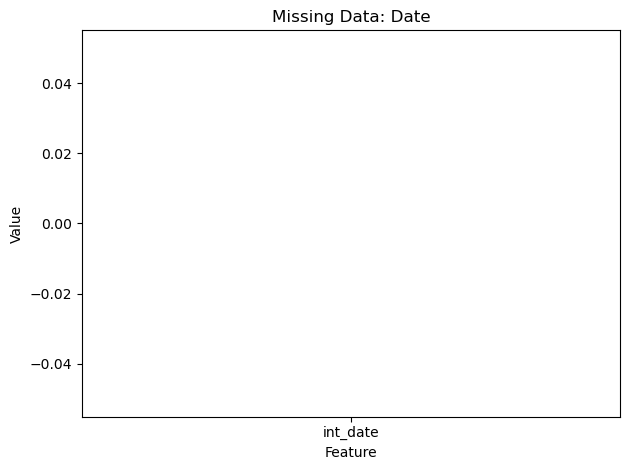

Feature: demog_capitationcoefficient, Data Exists: 99.91%, Data Missing: 0.00%
Feature: demog_customer_age, Data Exists: 99.91%, Data Missing: 0.00%
Missing Values Feature demog_capitationcoefficient: 0.09%
Missing Values Feature demog_customer_age: 0.09%


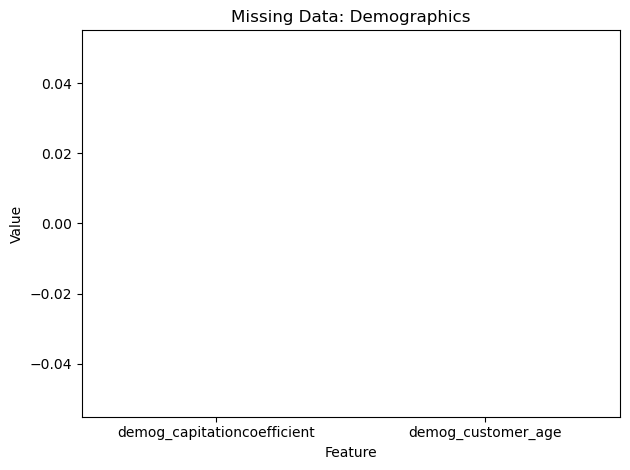

Feature: smoking_is_smoker, Data Exists: 67.31%, Data Missing: 33.00%
Feature: smoking_smoking_years, Data Exists: 67.31%, Data Missing: 33.00%
Feature: smoking_total_heavy_smokers, Data Exists: 67.31%, Data Missing: 33.00%
Feature: lab_b_hcg_abs_last_value, Data Exists: 99.99%, Data Missing: 0.00%
Feature: lab_NT_MoM_last_value, Data Exists: 99.61%, Data Missing: 0.00%
Feature: lab_weight_at_lab_time_last_value, Data Exists: 100.00%, Data Missing: 0.00%
Feature: lab_num_of_fetuses_last_value, Data Exists: 100.00%, Data Missing: 0.00%
Feature: lab_NT_abs_last_value, Data Exists: 99.61%, Data Missing: 0.00%
Feature: lab_papp_a_abs_last_value, Data Exists: 100.00%, Data Missing: 0.00%
Feature: lab_papp_a_MoM_last_value, Data Exists: 100.00%, Data Missing: 0.00%
Feature: lab_Protein-U_last_value, Data Exists: 57.57%, Data Missing: 42.00%
Feature: lab_Monocytes_1_last_value, Data Exists: 99.98%, Data Missing: 0.00%
Feature: lab_Mean Platelet Volume (MPV)_last_value, Data Exists: 99.26%, Da

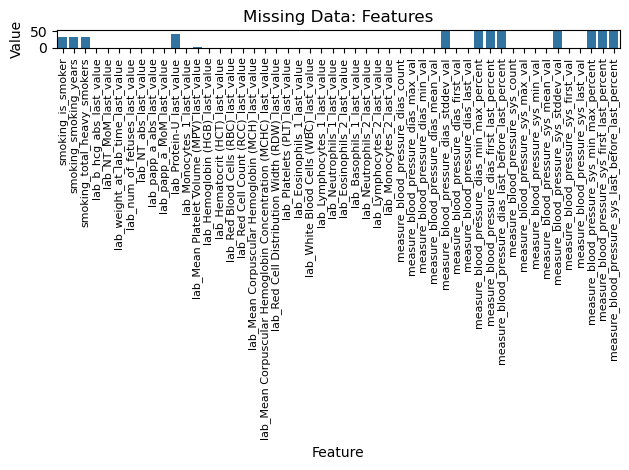

Feature: 24_diag_53_days_since_last_diag, Data Exists: 0.12%, Data Missing: 100.00%
Feature: 24_diag_54_num_of_diag, Data Exists: 100.00%, Data Missing: 0.00%
Feature: 24_diag_55_days_since_last_diag, Data Exists: 9.17%, Data Missing: 91.00%
Feature: 24_diag_56_num_of_diag, Data Exists: 100.00%, Data Missing: 0.00%
Feature: 24_diag_57_days_since_last_diag, Data Exists: 0.27%, Data Missing: 100.00%
Feature: 24_diag_58_num_of_diag, Data Exists: 100.00%, Data Missing: 0.00%
Feature: 24_diag_59_days_since_last_diag, Data Exists: 17.35%, Data Missing: 83.00%
Feature: 24_diag_60_num_of_diag, Data Exists: 100.00%, Data Missing: 0.00%
Feature: 24_diag_61_days_since_last_diag, Data Exists: 10.19%, Data Missing: 90.00%
Feature: 24_diag_62_num_of_diag, Data Exists: 100.00%, Data Missing: 0.00%
Feature: 24_diag_63_days_since_last_diag, Data Exists: 1.26%, Data Missing: 99.00%
Feature: 24_diag_64_num_of_diag, Data Exists: 100.00%, Data Missing: 0.00%
Feature: 24_diag_65_days_since_last_diag, Data E

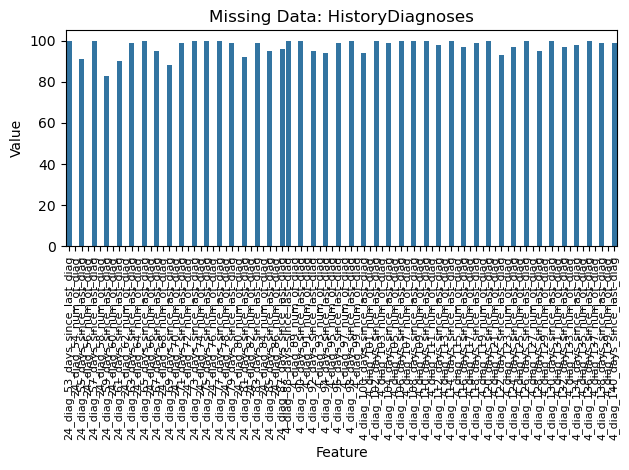

Feature: match_diag_141, Data Exists: 100.00%, Data Missing: 0.00%
Feature: match_measure_after, Data Exists: 100.00%, Data Missing: 0.00%
Feature: match_rasham_after, Data Exists: 100.00%, Data Missing: 0.00%
Feature: match_aspirin_after, Data Exists: 100.00%, Data Missing: 0.00%
Feature: match_pdf_after, Data Exists: 100.00%, Data Missing: 0.00%
Feature: Y, Data Exists: 100.00%, Data Missing: 0.00%
Feature: secondary_hypertension_sum, Data Exists: 100.00%, Data Missing: 0.00%
Feature: essential_hypertension_sum, Data Exists: 100.00%, Data Missing: 0.00%
Feature: hypertensive_heart_disease_sum, Data Exists: 100.00%, Data Missing: 0.00%
Feature: hypertensive_chronic_kidney_disease_sum, Data Exists: 100.00%, Data Missing: 0.00%
Feature: hypertensive_heart_and_chronic_kidney_disease_sum, Data Exists: 100.00%, Data Missing: 0.00%
Feature: pregnancy_hypertension_sum, Data Exists: 100.00%, Data Missing: 0.00%
Feature: preeclampsia_sum, Data Exists: 100.00%, Data Missing: 0.00%
Feature: ecla

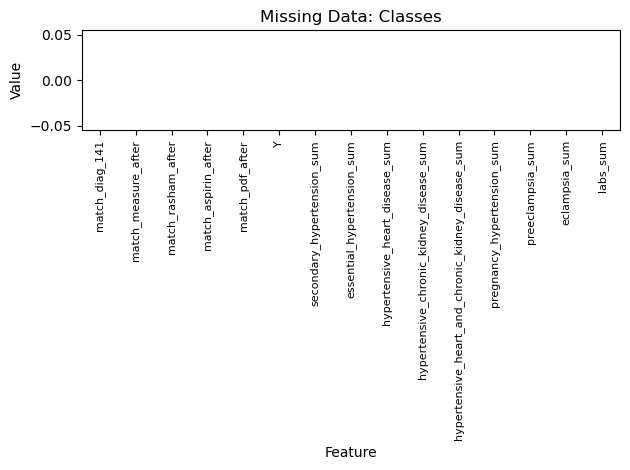

Feature: clinical_sheet, Data Exists: 100.00%, Data Missing: 0.00%


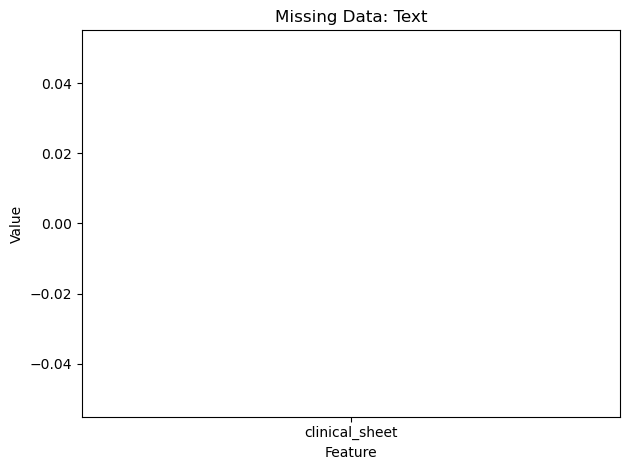

Dataset Category: Disorder Binary Ratio: . 
 Records: 2, Features: 2


<Figure size 640x480 with 0 Axes>

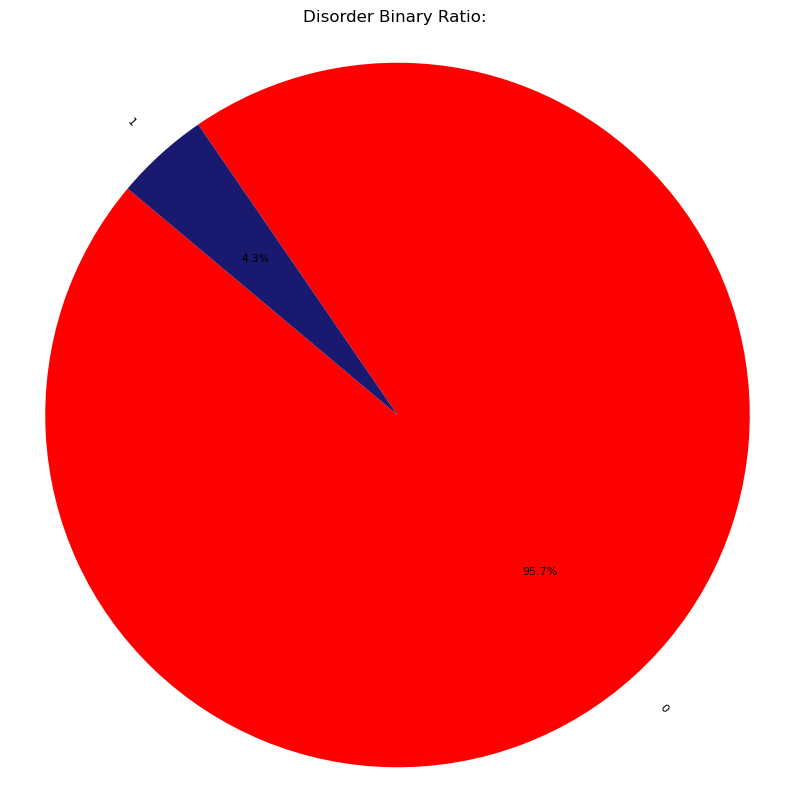

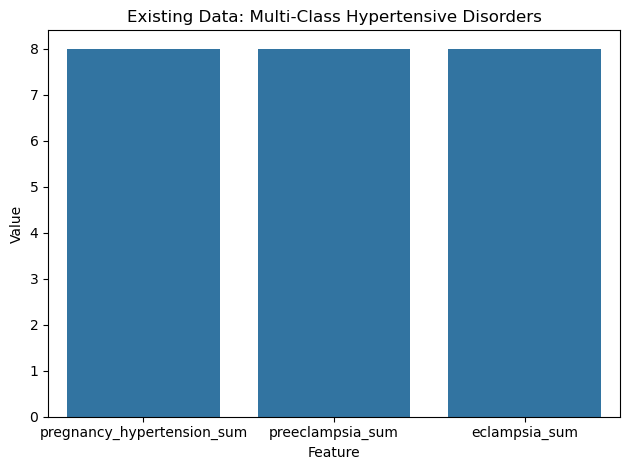

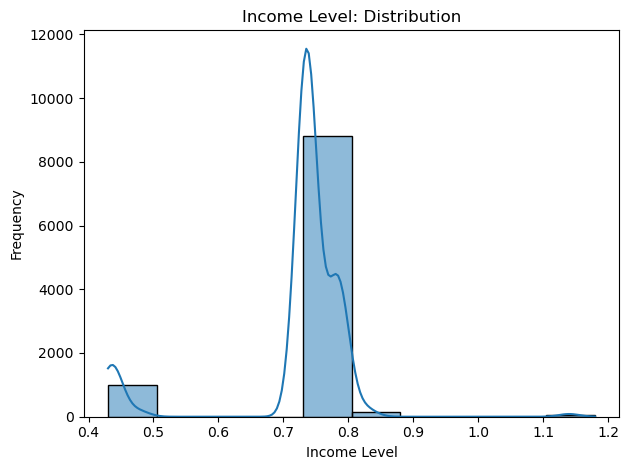

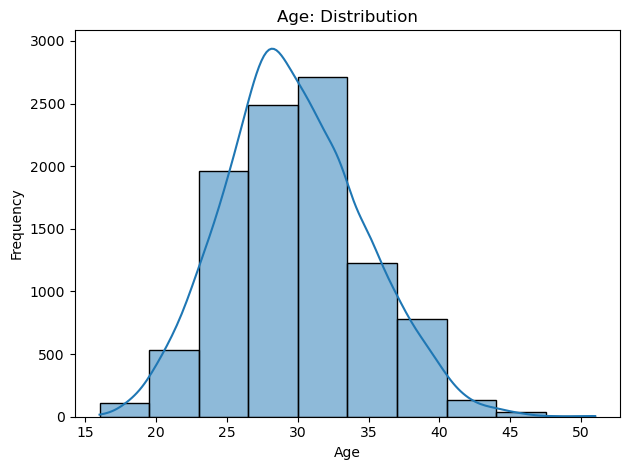

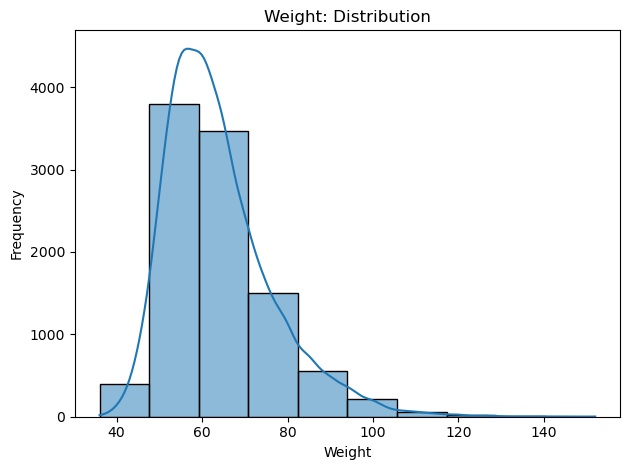

<Figure size 640x480 with 0 Axes>

In [51]:
# (4) EDA
data_analysis(df_data, d_cols, p_plots)

100%|█████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 977.08it/s]


Feature: int_date, Data Exists: 100.00%, Data Missing: 0.00%
Feature: 8_תלונות, Data Exists: 67.73%, Data Missing: 32.00%
Feature: 8_DiastolicBP, Data Exists: 9.81%, Data Missing: 90.00%
Feature: 8_SystolicBP, Data Exists: 9.81%, Data Missing: 90.00%
Feature: 8_בדיקת שתן, Data Exists: 0.89%, Data Missing: 99.00%
Feature: רחם_ממצאים, Data Exists: 0.02%, Data Missing: 100.00%
Feature: רחם_מעבדה, Data Exists: 0.18%, Data Missing: 100.00%
Feature: רחם_המלצות, Data Exists: 0.55%, Data Missing: 99.00%
Feature: 10_תלונות, Data Exists: 14.69%, Data Missing: 85.00%
Feature: 10_DiastolicBP, Data Exists: 2.16%, Data Missing: 98.00%
Feature: 10_SystolicBP, Data Exists: 2.16%, Data Missing: 98.00%
Feature: 10_מעבדה, Data Exists: 2.76%, Data Missing: 97.00%
Feature: 10_המלצות, Data Exists: 8.89%, Data Missing: 91.00%
Feature: 12_תלונות, Data Exists: 49.94%, Data Missing: 50.00%
Feature: 12_DiastolicBP, Data Exists: 7.71%, Data Missing: 92.00%
Feature: 12_SystolicBP, Data Exists: 7.71%, Data Missing:

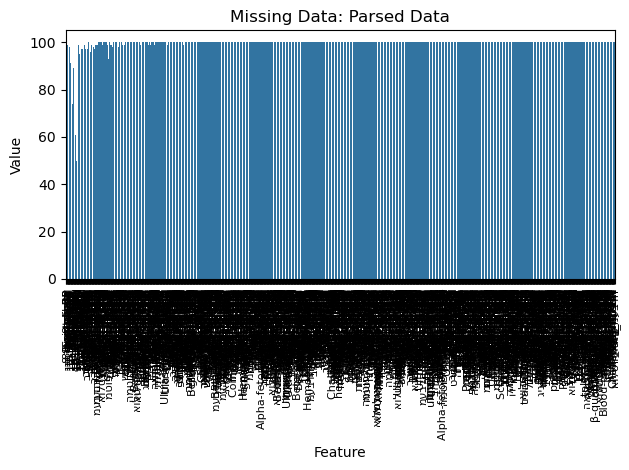

<Figure size 640x480 with 0 Axes>

In [52]:
# (5) Preprocessing Data: (5.1) Text Data and (5.2) Tabular Data
df_data_preprocessed = preprocess_data(df_data, col_text, p_outputs)

In [53]:
# (6) Model CV
x_train, y_train, x_test, y_test, o_model, s_model, y_probs = model_cv(df_data_preprocessed, d_cols, p_resources, p_outputs, p_models, _threshold_fixed_percentage)  # b_shuffle=False, i_cv=3)

Preprocessing Data...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1622 columns):
 #     Column                                                           Dtype  
---    ------                                                           -----  
 0     int_date                                                         int64  
 1     demog_capitationcoefficient                                      float64
 2     demog_customer_age                                               float64
 3     smoking_is_smoker                                                float64
 4     smoking_smoking_years                                            float64
 5     smoking_total_heavy_smokers                                      float64
 6     lab_b_hcg_abs_last_value                                         float64
 7     lab_NT_MoM_last_value                                            float64
 8     lab_weight_at_lab_time_last_value                            

/home/edoli/.conda/envs/tfgpu_jup/lib/python3.9/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/edoli/.conda/envs/tfgpu_jup/lib/python3.9/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/edoli/.conda/envs/tfgpu_jup/lib/python3.9/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Training Model XGBoost...
Finished training in: 0.00 hours (0.01 minutes).
Inferring Model XGBoost...
Finished testing in: 0.00 hours (0.00 minutes).
Results: True Cases: 1.0
Results: Accuracy: 1.0, AUC: 1.0, precision: 1.0, recall: 1.0, f1: 1.0, PRAUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1914
           1       1.00      1.00      1.00        86

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Saved Model: XGBoost
Percentage of predictions within 5 units: 100.00%


/tmp/ipykernel_3017065/2244619402.py:393: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  curr_score = percentage_score[0]


In [54]:
# (7) Explainability: Local Shap
i_record = 5
data_explainability(x_train, y_train, x_test, i_record)

/home/edoli/.conda/envs/tfgpu_jup/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [55]:
# (8) Fairness and Calibration: (8.1) Age and (8.2) Income Level
l_fairness_features = ['demog_customer_age', 'demog_capitationcoefficient']
data_fairness(l_fairness_features, x_train, y_train, x_test, y_test, o_model, s_model, y_probs)

Future Work:

   Finish the following code tasks (TODO because of time limitation):
   
1) Imputation of features containing missing values
2) Standardization of continuous features
3) Feature engineering: MAP, PP and WLR
4) Shap local force plot
5) Calibration plot for features age and income level
6) Adding clinical note text features also by rows by aggregated report information of weeks –> better model learning stability
7) Data split by a balanced ratio of disorder and by real-world ratio settings

   Additional Experiments:
   
8) K-fold cross validation: [3, 5, 10]
9) Text parser expanding Hebrew stop-words
10) N-grams: [(1,2 ), (1, 3)]
11) Max-features: [100, 1000, 5000, 10000, None (all)]
12) Model Hyperoptimization: Bayesian Optimization
13) Data augmentations sets
14) Pretrained transformer model: BERT, roBERTa, GPT and T5
15) Fine-tuning model: Incorporating additional text sources of Gestational hypertension, Preeclampsia hypertension and Eclampsia disorders

    Additional Explainability Methods:
    
17) Local methods: Local Interpretable Model-Agnostic Explanations (LIME), Individual Conditional Expectation (ICE) and Anchors
18) Global methods: Partial Dependence Plot (PDP), Accumulated Local Effects (ALE) and Global Surrogate Models (Decision Tree/Logistic Regression)